# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"
plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import Common, NetCDFInitialization
from gpuocean.SWEsimulators import CDKLM16, CDKLM16pair

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [3]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [4]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    }

In [5]:
loc = [[50,50],[250,450]]
scale = 1.5
# NOTE: We use constant 
# Could also be lists of length L

## Sample size

In [6]:
N = 5

## Levels

In [7]:
L = 3

In [8]:

gpu_ctxs = []
for i in range(L+1):
    gpu_ctxs.append(Common.CUDAContext())

slave_gpu_ctxs = []
for i in range(L+1):
    slave_gpu_ctxs.append(Common.CUDAContext())

# Mean Estimator $\mathbb{E}\lVert u^l - u^{l-1} \rVert_{D^l}$

In [10]:
for n in range(N):
    # Set up new simulations
    sim = CDKLM16.CDKLM16(gpu_ctxs[0], **sim_args, **data_args)
    slave = CDKLM16.CDKLM16(slave_gpu_ctxs[0], **sim_args, **data_args)   

    # Initialise L levels
    child = sim
    slave_child = slave
    for l in range(1,L+1):
        child.give_birth(gpu_ctxs[l], loc, scale)
        child = child.children[0]
        if l < L:
            slave_child.give_birth(slave_gpu_ctxs[l], loc, scale)
            slave_child = slave_child.children[0]

    # pair slave and step ahead in time
    sim_pair = CDKLM16pair.CDKLM16pair(sim, slave, small_scale_model_error=True, interpolation_factor=21)
    for five in range(5): 
        sim_pair.step(300, apply_stochastic_term=True) # model error after every step()-call
    
    # Finest levels
    level_sim = sim_pair.sim
    slave_level_sim = sim_pair.slave_sim
    for l in range(1,L+1):
        level_sim = level_sim.children[0]
        if l < L:
            slave_level_sim = slave_level_sim.children[0]
    
    eta, hu, hv = level_sim.download()
    slave_level_sim.give_birth(slave_gpu_ctxs[-1], loc, scale)
    slave_eta, slave_hu, slave_hv = slave_level_sim.children[0].download()
    slave_level_sim.kill_child()

    if n==0:
        Ediff = np.ma.array([(eta - slave_eta)/N, (hu - slave_hu)/N, (hv - slave_hv)/N])
    else:
        Ediff += np.ma.array([(eta - slave_eta)/N, (hu - slave_hu)/N, (hv - slave_hv)/N])

    if n==0:
        E = np.ma.array([eta/N, hu/N, hv/N])
    else:
        E += np.ma.array([eta/N, hu/N, hv/N])

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

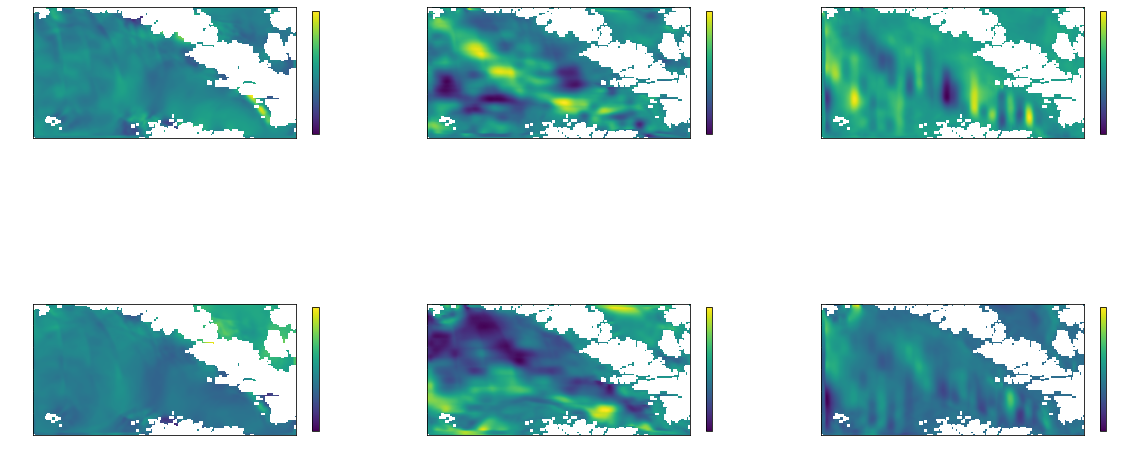

In [11]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

im = axs[0,0].imshow(Ediff[0])
plt.colorbar(im, ax=axs[0,0], shrink=0.5)

im = axs[0,1].imshow(Ediff[1])
plt.colorbar(im, ax=axs[0,1], shrink=0.5)

im = axs[0,2].imshow(Ediff[2])
plt.colorbar(im, ax=axs[0,2], shrink=0.5)


im = axs[1,0].imshow(E[0])
plt.colorbar(im, ax=axs[1,0], shrink=0.5)

im = axs[1,1].imshow(E[1])
plt.colorbar(im, ax=axs[1,1], shrink=0.5)

im = axs[1,2].imshow(E[2])
plt.colorbar(im, ax=axs[1,2], shrink=0.5)

# Variance Estimator

In [12]:
for n in range(N):
    # Set up new simulations
    sim = CDKLM16.CDKLM16(gpu_ctxs[0], **sim_args, **data_args)
    slave = CDKLM16.CDKLM16(slave_gpu_ctxs[0], **sim_args, **data_args)   

    # Initialise L levels
    child = sim
    slave_child = slave
    for l in range(1,L+1):
        child.give_birth(gpu_ctxs[l], loc, scale)
        child = child.children[0]
        if l < L:
            slave_child.give_birth(slave_gpu_ctxs[l], loc, scale)
            slave_child = slave_child.children[0]

    # pair slave and step ahead in time
    sim_pair = CDKLM16pair.CDKLM16pair(sim, slave, small_scale_model_error=True, interpolation_factor=21)
    for five in range(5): 
        sim_pair.step(300, apply_stochastic_term=True) # model error after every step()-call
    
    # Finest levels
    level_sim = sim_pair.sim
    slave_level_sim = sim_pair.slave_sim
    for l in range(1,L+1):
        level_sim = level_sim.children[0]
        if l < L:
            slave_level_sim = slave_level_sim.children[0]
    
    eta, hu, hv = level_sim.download()
    slave_level_sim.give_birth(slave_gpu_ctxs[-1], loc, scale)
    slave_eta, slave_hu, slave_hv = slave_level_sim.children[0].download()
    slave_level_sim.kill_child()

    if n == 0:
        VarDiff = np.ma.array([((eta - slave_eta) - Ediff[0])**2/(N-1), ((hu - slave_hu) - Ediff[1])**2/(N-1), ((hv - slave_hv) - Ediff[2])**2/(N-1)])
    else:
        VarDiff += np.ma.array([((eta - slave_eta) - Ediff[0])**2/(N-1), ((hu - slave_hu) - Ediff[1])**2/(N-1), ((hv - slave_hv) - Ediff[2])**2/(N-1)])

    if n==0:
        Var = np.ma.array([(eta - E[0])**2/(N-1), (hu - E[1])**2/(N-1), (hv - E[2])**2/(N-1)])
    else:
        Var += np.ma.array([(eta - E[0])**2/(N-1), (hu - E[1])**2/(N-1), (hv - E[2])**2/(N-1)])

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

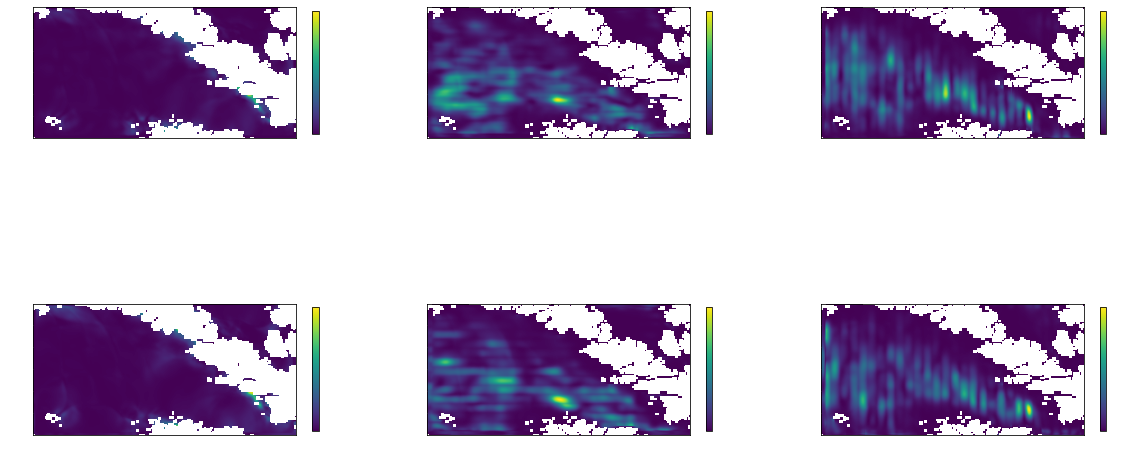

In [16]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

im = axs[0,0].imshow(VarDiff[0])
plt.colorbar(im, ax=axs[0,0], shrink=0.5)

im = axs[0,1].imshow(VarDiff[1])
plt.colorbar(im, ax=axs[0,1], shrink=0.5)

im = axs[0,2].imshow(VarDiff[2])
plt.colorbar(im, ax=axs[0,2], shrink=0.5)


im = axs[1,0].imshow(Var[0])
plt.colorbar(im, ax=axs[1,0], shrink=0.5)

im = axs[1,1].imshow(Var[1])
plt.colorbar(im, ax=axs[1,1], shrink=0.5)

im = axs[1,2].imshow(Var[2])
plt.colorbar(im, ax=axs[1,2], shrink=0.5)

In [14]:
[np.linalg.norm(field)/np.prod(field.shape) for field in Var]

[0.00016137821409437393, 1.5590402777777779, 1.4277109375]

In [15]:
[np.linalg.norm(field)/np.prod(field.shape) for field in VarDiff]

[0.0002215089374118381, 2.8653166666666667, 2.858302777777778]